In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def rand_times(n):
    """Generate n rows of random 24-hour times (seconds past midnight)"""
    rand_seconds = np.random.randint(0, 24*60*60, n)
    return pd.DataFrame(data=dict(seconds=rand_seconds))

n_rows = 1000

df = rand_times(n_rows)
# sort for the sake of graphing
df = df.sort_values('seconds').reset_index(drop=True)
df.head()

,seconds
0,92
1,119
2,145
3,191
4,276


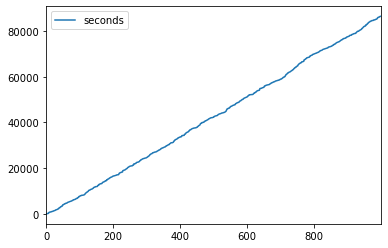

In [9]:
import seaborn as sns
df.plot()

Notice that the distance between a point as 5 minutes before and 5 minutes after the split is very large. This is undesirable: we want our machine learning model to see that 23:55 and 00:05 are 10 minutes apart, but as it stands, those times will appear to be 23 hours and 50 minutes apart!

## Transformation into 2 dimensions


Here’s the trick: we will create two new features, deriving a sine transform and cosine transform of the seconds-past-midnight feature. We can forget the raw “seconds” column from now on.

In [11]:
seconds_in_day = 24*60*60

df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_in_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_in_day)

df.drop('seconds', axis=1, inplace=True)

df.head()

,sin_time,cos_time
0,0.006690,0.999978
1,0.008654,0.999963
2,0.010545,0.999944
3,0.013889,0.999904
4,0.020070,0.999799


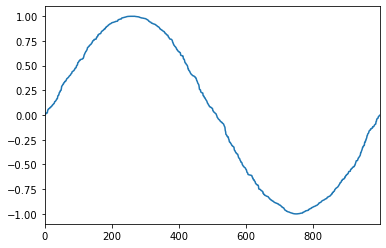

In [12]:
df.sin_time.plot();

Notice that now, 5 minutes before midnight and 5 minutes after is 10 minutes apart, just as we wanted.

However, with just this sine transformation, you get a weird side-effect. Notice that every horizontal line you draw across the graph touches two points. So from this feature alone, it appears that midnight==noon, 1:15am==10:45am, and so on. There is nothing to break the symmetry across the period. We really need two dimensions for a cyclical feature. Cosine to the rescue!

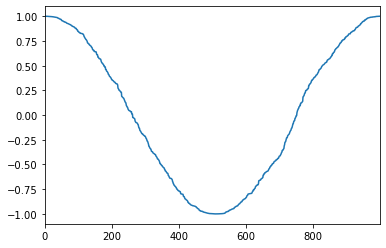

In [13]:
df.cos_time.plot();

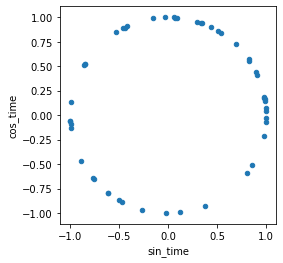

In [14]:
df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');


In [6]:
## Let take an Example

In [5]:
import pandas as pd

df = pd.read_csv('Bike-Sharing-Dataset/hour.csv')
print(df.columns.values)


['instant' 'dteday' 'season' 'yr' 'mnth' 'hr' 'holiday' 'weekday'
 'workingday' 'weathersit' 'temp' 'atemp' 'hum' 'windspeed' 'casual'
 'registered' 'cnt']


It looks like there are a bunch of features in here that are likely valuable to predict cnt, the count of users riding bikes (probably the sum of "casual" riders and "registered" riders). Let's have a look at the mnth (month) feature, and the hr (hour) feature and try to transform them a la Mr. Dossman.

In [7]:
df = df[['mnth','hr','cnt']].copy()

In [9]:
print('Unique values of month:',df.mnth.unique())
print('Unique values of hour:',df.hr.unique())


Unique values of month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Unique values of hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


So far, so logical. Months are numbered one through twelve, and hours are numbered 0 through 23.

**Now the magic happens. We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions. You remember your unit circle, right? Here's what it looks like for the "hours" variable. Zero (midnight) is on the right, and the hours increase counterclockwise around the circle. In this way, 23:59 is very close to 00:00, as it should be.**



In [10]:
import numpy as np

df['hr_sin'] = np.sin(df.hr*(2.*np.pi/24))
df['hr_cos'] = np.cos(df.hr*(2.*np.pi/24))
df['mnth_sin'] = np.sin((df.mnth-1)*(2.*np.pi/12))
df['mnth_cos'] = np.cos((df.mnth-1)*(2.*np.pi/12))

Now instead of hours extending from 0 to 23, we have two new features "hr_sin" and "hr_cos" which each extend from 0 to 1 and combine to have the nice cyclical characteristics we're after.

The claim is that using this transform will improve the predictive performance of our models. Let's give it a shot!

## Impact on Model Performance

To begin, let's try to use just the nominal hours and month features to predict the number of bikes being ridden. I'll use a basic sklearn neural network and see how well it performs with K-fold cross validation. The loss function I'll use is (negative) mean squared error. I'll also use a standard scaler in an sklearn Pipeline, though it probably isn't necessary given the range in values of our two features.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

# Construct the pipeline with a standard scaler and a small neural network
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn', MLPRegressor(hidden_layer_sizes=(5,), max_iter=1000)))
model = Pipeline(estimators)

# To begin, let's use only these two features to predict 'cnt' (bicycle count)
features = ['mnth','hr']
X = df[features].values
y = df.cnt

# We'll use 5-fold cross validation. That is, a random 80% of the data will be used
# to train the model, and the prediction score will be computed on the remaining 20%.
# This process is repeated five times such that the training sets in each "fold"
# are mutually orthogonal.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)

results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
print('CV Scoring Result: mean=',np.mean(results),'std=',np.std(results))

c:\users\roshan\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CV Scoring Result: mean= -30526.468958382764 std= 13293.82473902038


That's a pretty large average MSE, but that's the point. The neural network struggles to interpret month and hour features because they aren't represented in a logical (cyclical) way. These features are more categorical than numerical, which is a problem for the network.

Let's repeat the same exercise, but using the four newly engineered features we created above.

In [ ]:
features = ['mnth_sin','mnth_cos','hr_sin','hr_cos']
X = df[features].values

results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
print('CV Scoring Result: mean=',np.mean(results),'std=',np.std(results))

c:\users\roshan\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\roshan\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\roshan\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Success! The average MSE improved by almost 25% (remember this is negative MSE so the closer to zero the better)

To be clear, I'm not saying that this model will do a good job at predicting the number of bikes being ridden, but taking this feature engineering step for the cyclical features definitely helped. The model had an easier time interpreting the engineered features. What's nice is that this feature engineering method not only improves performance, but it does it in a logical way that humans can understand. I'll definitely be employing this technique in my future analyses, and I hope you do too.